In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    from skforecast.ForecasterAutoreg import ForecasterAutoreg, ForecastAutoregDirect
    from skforecast.model_selection import grid_search_forecaster
    from skforecast.model_selection import backtesting_forecaster
    import xgboost as xgb
except:
    !pip install --quiet skforecast
    !pip install --quiet xgboost
    from skforecast.ForecasterAutoreg import ForecasterAutoreg
    from skforecast.model_selection import backtesting_forecaster
    from skforecast.model_selection import grid_search_forecaster
    import xgboost as xgb

In [16]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import xgboost as xgb

In [17]:
# from drive.MyDrive.CEU.MASZK_predicitons_weekly.helpers import *
from helpers import *
#
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
#!pip install --quiet matplotlib
#
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["font.size"]=14

In [32]:
# path= "/content/drive/MyDrive/CEU/MASZK_predicitons_weekly/"
path="data"
agg='day'

In [33]:
num_contact, behavior, contact_dyn= read_data(path,agg=agg)
df=contact_dyn.join(behavior, how="outer")
df["weekday"]=df.index.map(lambda x: x.weekday())
df=df.dropna()
 #
exog_cols= ['fraction_mask', 'fraction_travel_abroad','fraction_travel_settlement', 'infectednum',
             'C1M_School closing',
             'C2M_Workplace closing', 'C3M_Cancel public events',
             'C4M_Restrictions on gatherings', 'C5M_Close public transport',
             'C6M_Stay at home requirements',
             'C7M_Restrictions on internal movement',
             'C8EV_International travel controls',
             'H1_Public information campaigns','weekday']

#exog_cols= [
#            'C1M_School closing',
#            'C2M_Workplace closing', 'C3M_Cancel public events',
#            'C4M_Restrictions on gatherings', 'C5M_Close public transport',
#            'C6M_Stay at home requirements',
#            'C7M_Restrictions on internal movement',
#            'C8EV_International travel controls',
#            'H1_Public information campaigns']


In [34]:
import os
#exog_cols= ['fraction_mask', "fraction_travel_settlement"]
gridsearch_every=np.inf
exp_name=f"figs_all_weekday_lags14_{str(gridsearch_every)}_{agg}"
if not os.path.exists(path+exp_name):
   # Create a new directory because it does not exist
   os.makedirs(path+exp_name)
print(exp_name)

filePath=pathlib.Path("saved")
filePath.mkdir(parents=True, exist_ok=True)
#
figPath=pathlib.Path("figs")
figPath.mkdir(parents=True, exist_ok=True)

figs_all_weekday_lags14_inf_day


In [35]:
params= dict(
                 reg_alpha=0.01, 
                 reg_lambda=.1, 
                 n_estimators=500, 
                 max_depth=5,
                 learning_rate= .1)
    

In [36]:
steps= 14
lags= 7
regressor= xgb.XGBRegressor(**params)
end_train= df.index[0] + datetime.timedelta(days=28)
target_col="all_contact"

In [37]:
forecaster= ForecasterAutoregDirect(
    regressor= regressor,
    steps=steps,
    lags=lags
)

In [40]:
forecast= forecaster.fit(y= df.loc[:end_train, target_col],
                         exog=df.loc[:end_train, exog_cols])

In [64]:
metric, prediction_back_test= backtesting_forecaster(
                        forecaster= forecaster,
                        y= df[target_col],
                        initial_train_size= len(df.loc[:end_train]),
                        fixed_train_size= False,
                        steps=7,
                        metric="mean_squared_error",
                        refit=True,
                        verbose=True,
                        allow_incomplete_fold=True, 
                        exog=df[exog_cols])

/opt/miniconda3/envs/ts/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:454: LongTrainingWarning: The forecaster will be fit 784 times (56 folds * 14 regressors). This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


Information of backtesting process
----------------------------------
Number of observations used for initial training: 29
Number of observations used for backtesting: 388
    Number of folds: 56
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2020-03-23 00:00:00 -- 2020-04-20 00:00:00  (n=29)
    Validation: 2020-04-21 00:00:00 -- 2020-04-27 00:00:00  (n=7)
Fold: 1
    Training:   2020-03-23 00:00:00 -- 2020-04-27 00:00:00  (n=36)
    Validation: 2020-04-28 00:00:00 -- 2020-05-04 00:00:00  (n=7)
Fold: 2
    Training:   2020-03-23 00:00:00 -- 2020-05-04 00:00:00  (n=43)
    Validation: 2020-05-05 00:00:00 -- 2020-05-11 00:00:00  (n=7)
Fold: 3
    Training:   2020-03-23 00:00:00 -- 2020-05-11 00:00:00  (n=50)
    Validation: 2020-05-12 00:00:00 -- 2020-05-18 00:00:00  (n=7)
Fold: 4
    Training:   2020-03-23 00:00:00 -- 2020-05-18 00:00:00  (n=57)
    V

 39%|███▉      | 22/56 [00:34<01:07,  1.98s/it]

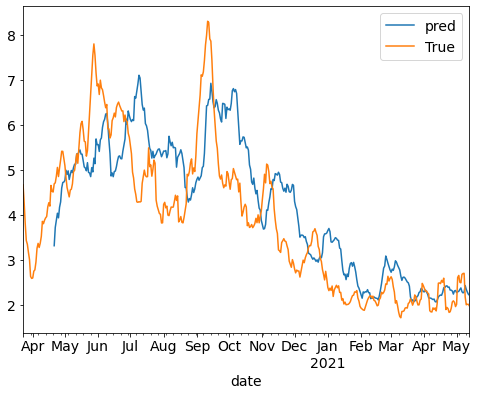

In [63]:
fig, ax= plt.subplots(figsize=(8, 6))
prediction_back_test.rolling("7D").mean().plot(ax=ax)
df[target_col].rolling("7D").mean().plot(label="True", ax=ax)
plt.legend(["pred", "True"])

In [203]:
#
target_col="all_contact"
# No exogeneous
#, importance, params_list= forecast(df, target_col, exog_cols=None,gridsearch_every=gridsearch_every,agg=agg)
#forecast_by_steps= get_forecast_by_steps(predictions)
predictions=None
importance=None
params_list=None
forecast_by_steps=None

# # Exogeneous
predictions_exog, importance_exog, params_list =forecast(df, target_col=target_col, exog_cols=exog_cols,gridsearch_every=gridsearch_every,agg=agg)
forecast_by_steps_exog= get_forecast_by_steps(predictions_exog)
# #

lags 2
Number of models compared: 360.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/360 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.01, 'reg_lambda': 0.05}
  Backtesting metric: 0.2839676463500173

lags= [1 2]
regressor params= {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.5, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': None

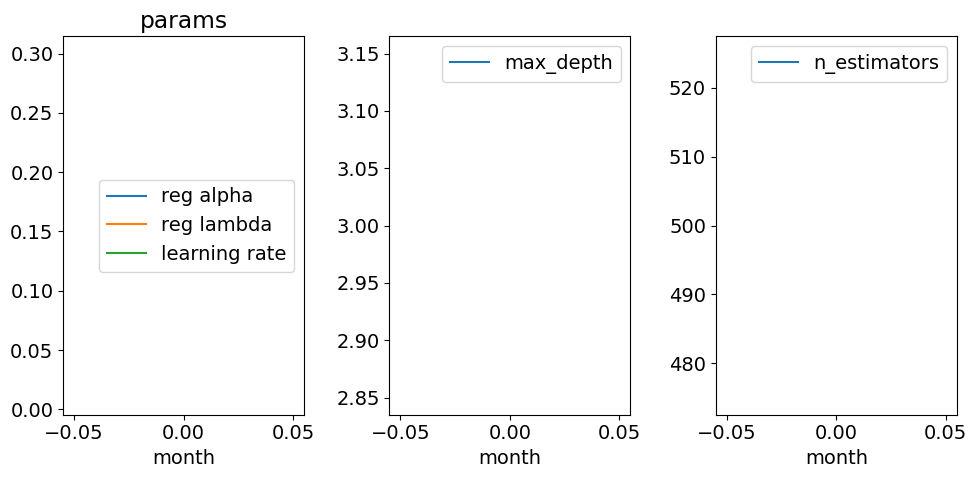

In [177]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot([param['reg_alpha'] for param in params_list])
plt.plot([param['reg_lambda'] for param in params_list])
plt.plot([param['learning_rate'] for param in params_list])
plt.legend(["reg alpha","reg lambda", "learning rate"])
plt.xlabel("month")
plt.title("params")
plt.subplot(1,3,2)
plt.plot([param['max_depth'] for param in params_list])
plt.legend(["max_depth"])
plt.xlabel("month")
plt.subplot(1,3,3)
plt.plot([param['n_estimators'] for param in params_list])
plt.legend(["n_estimators"])
plt.xlabel("month")
plt.tight_layout()



In [204]:
import pickle

with open(path+exp_name+'/importance.pickle', 'wb') as handle:
    pickle.dump([predictions, importance, predictions_exog, importance_exog], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [205]:
#import pickle

#with open(path+filePath.name+'/importance_frac_mask.pickle', 'rb') as handle:
#    tmp_read = pickle.load(handle)
#predictions=tmp_read[0]
#importance=tmp_read[1]
#predictions_exog=tmp_read[2]
#importance_exog=tmp_read[3]

#target_col="all_contact"
#forecast_by_steps= get_forecast_by_steps(predictions)
#forecast_by_steps_exog= get_forecast_by_steps(predictions_exog)

In [206]:
importance_exog_dict={}
for feature in importance_exog[0]["feature"].values:
  importance_exog_dict[feature]=[]
  for i in range(len(importance_exog)):
      importance_exog_dict[feature].append(importance_exog[i].set_index("feature")["importance"][feature])

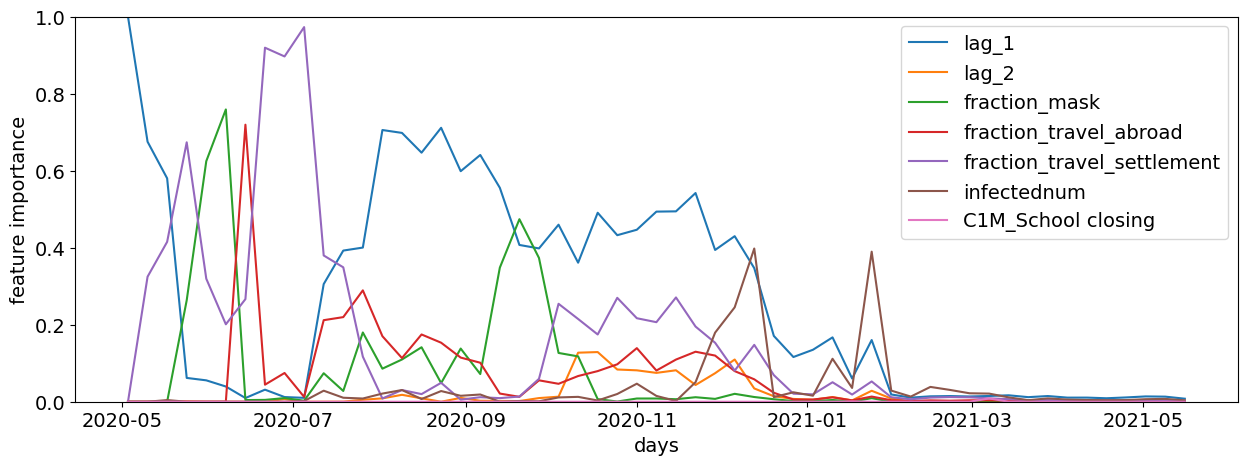

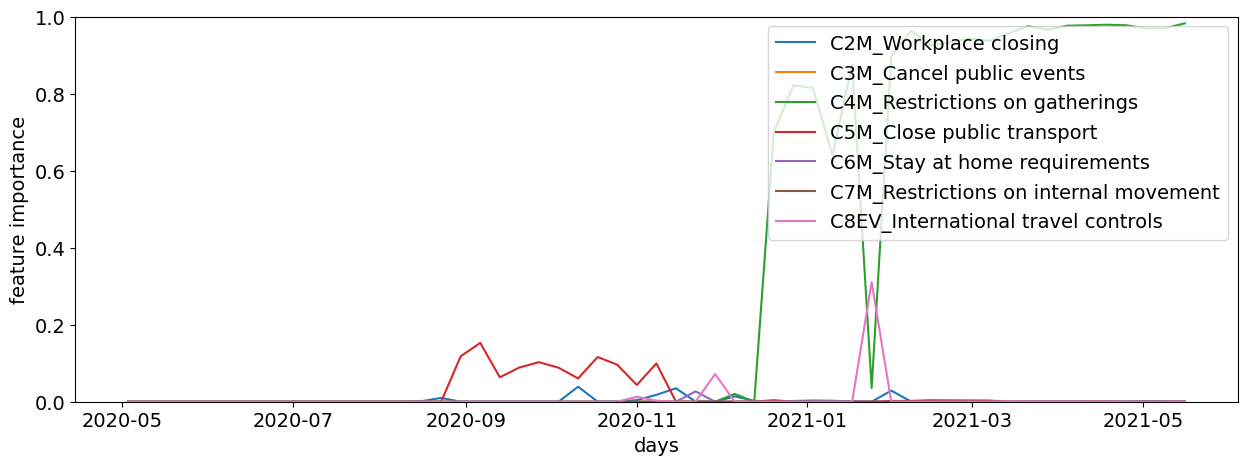

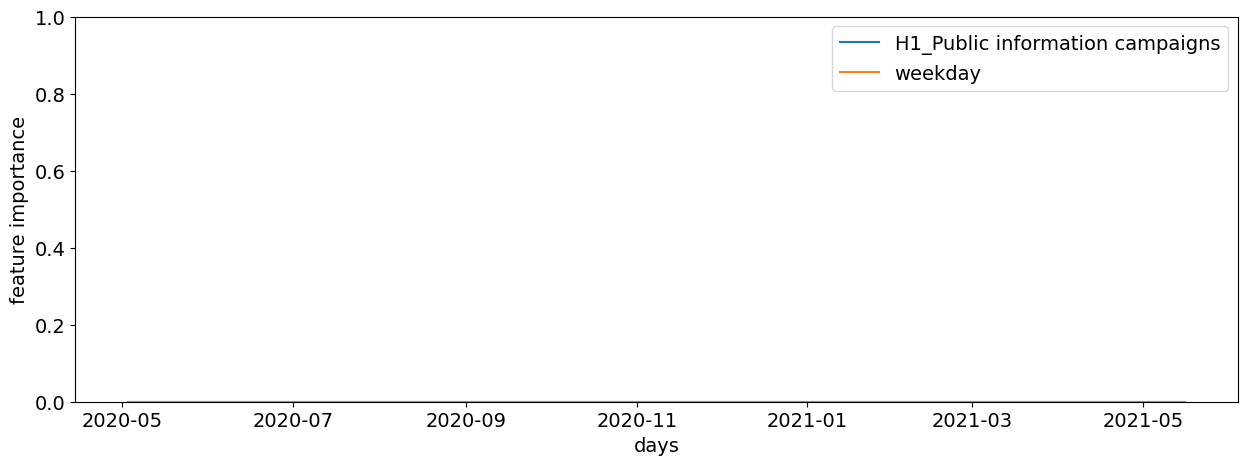

In [207]:
for j in range(len(importance_exog[0]["feature"].values)//7+1):
  plt.figure(figsize=(15,5))
  for feature in importance_exog[0]["feature"].values[j*7:(j+1)*7]:
    plt.plot(df.index[-(len(importance_exog)):],importance_exog_dict[feature])
  plt.legend(importance_exog[0]["feature"].values[j*7:(j+1)*7],loc="upper right")
  plt.ylim([0,1])
  plt.ylabel("feature importance")
  plt.xlabel("days")
  plt.savefig(path+exp_name+"/importance_"+str(j)+".jpg")

In [208]:
forecast_by_steps=forecast_by_steps_exog


In [209]:
predictions_exog[0]

,pred
2020-05-03,5.033054
2020-05-10,5.033054


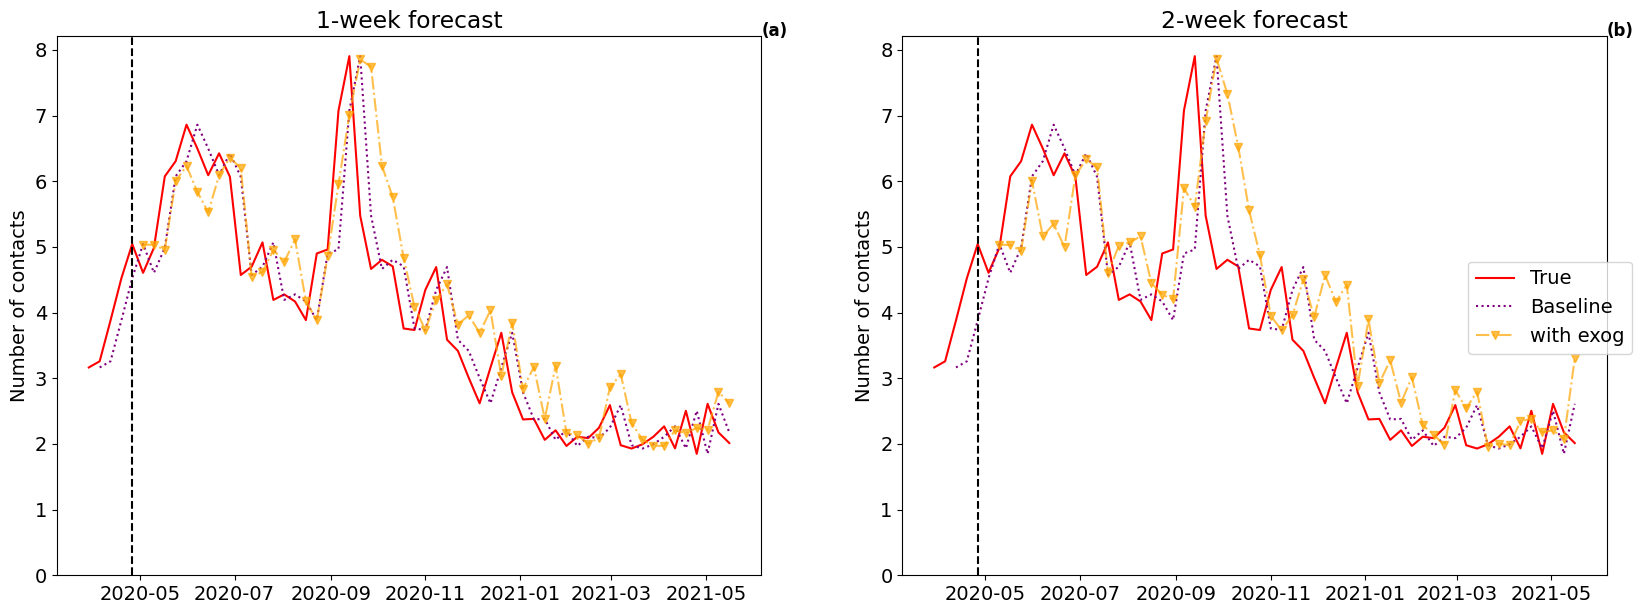

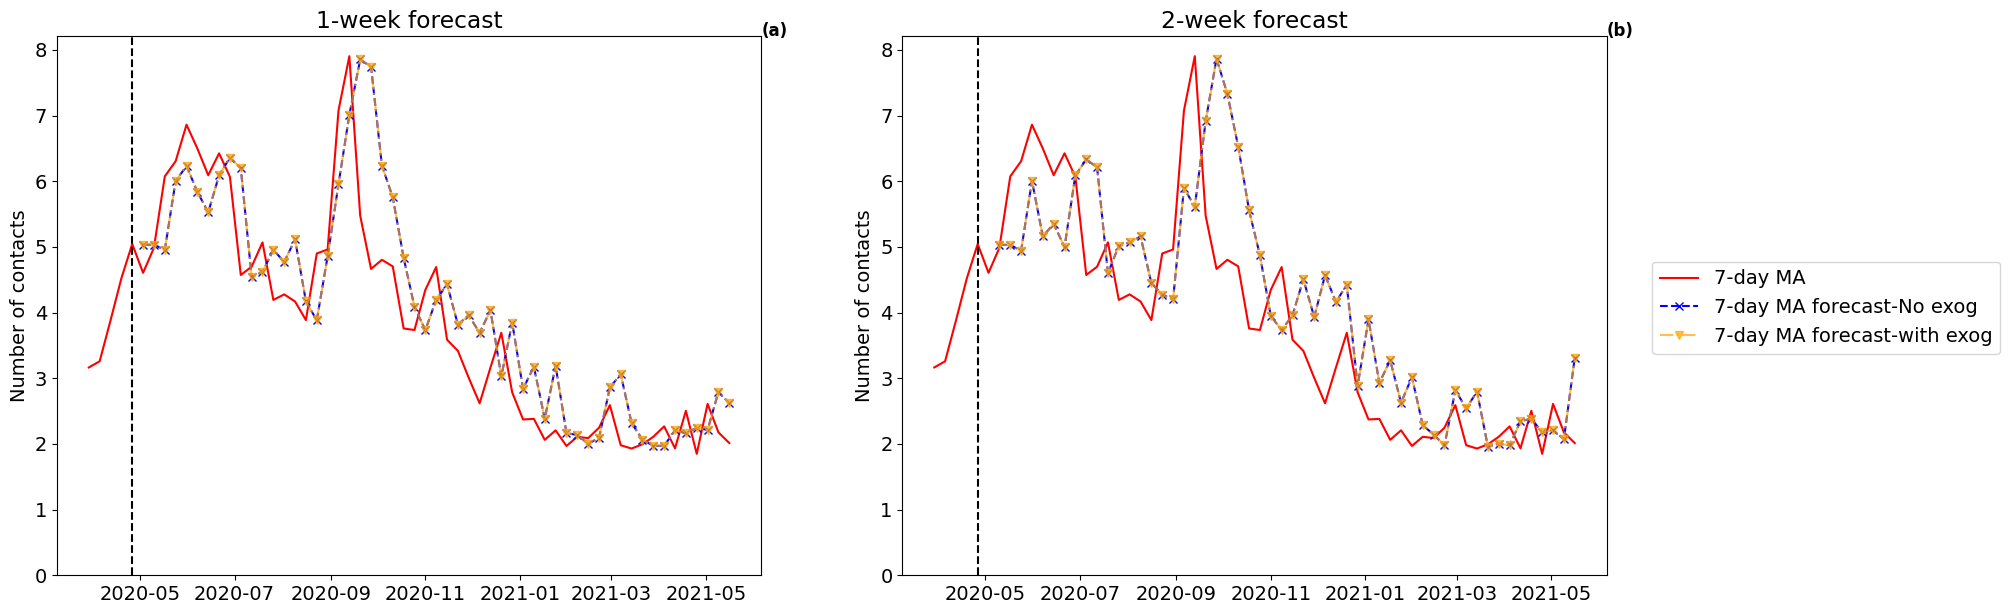

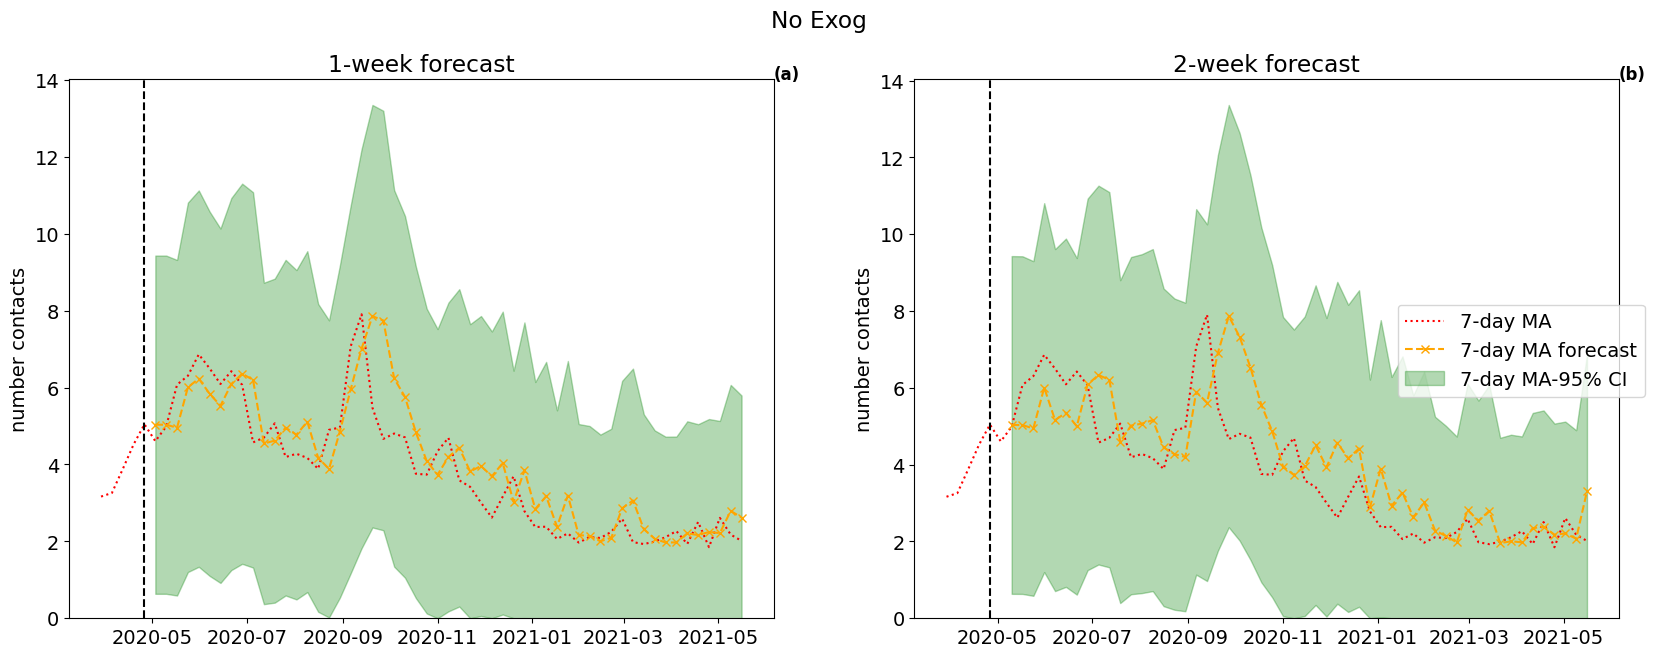

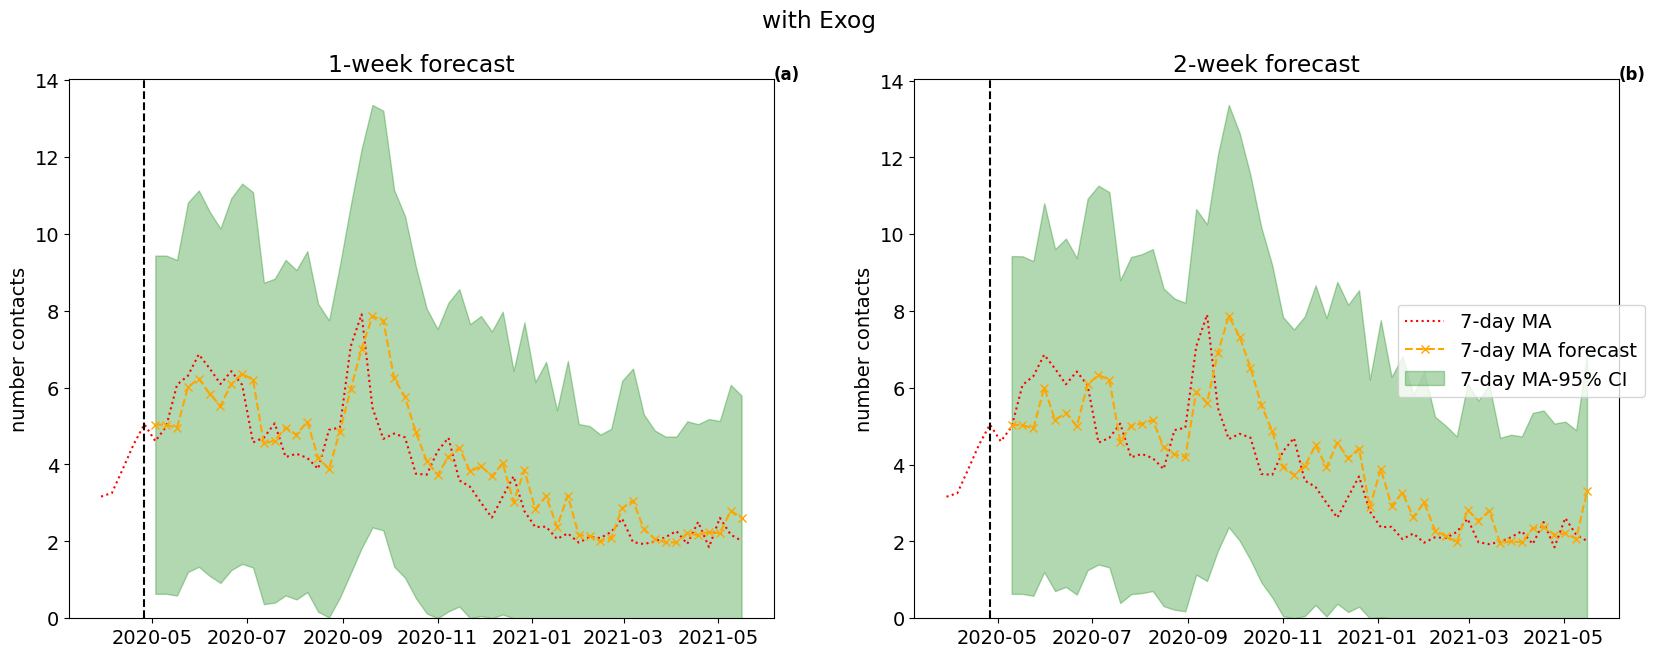

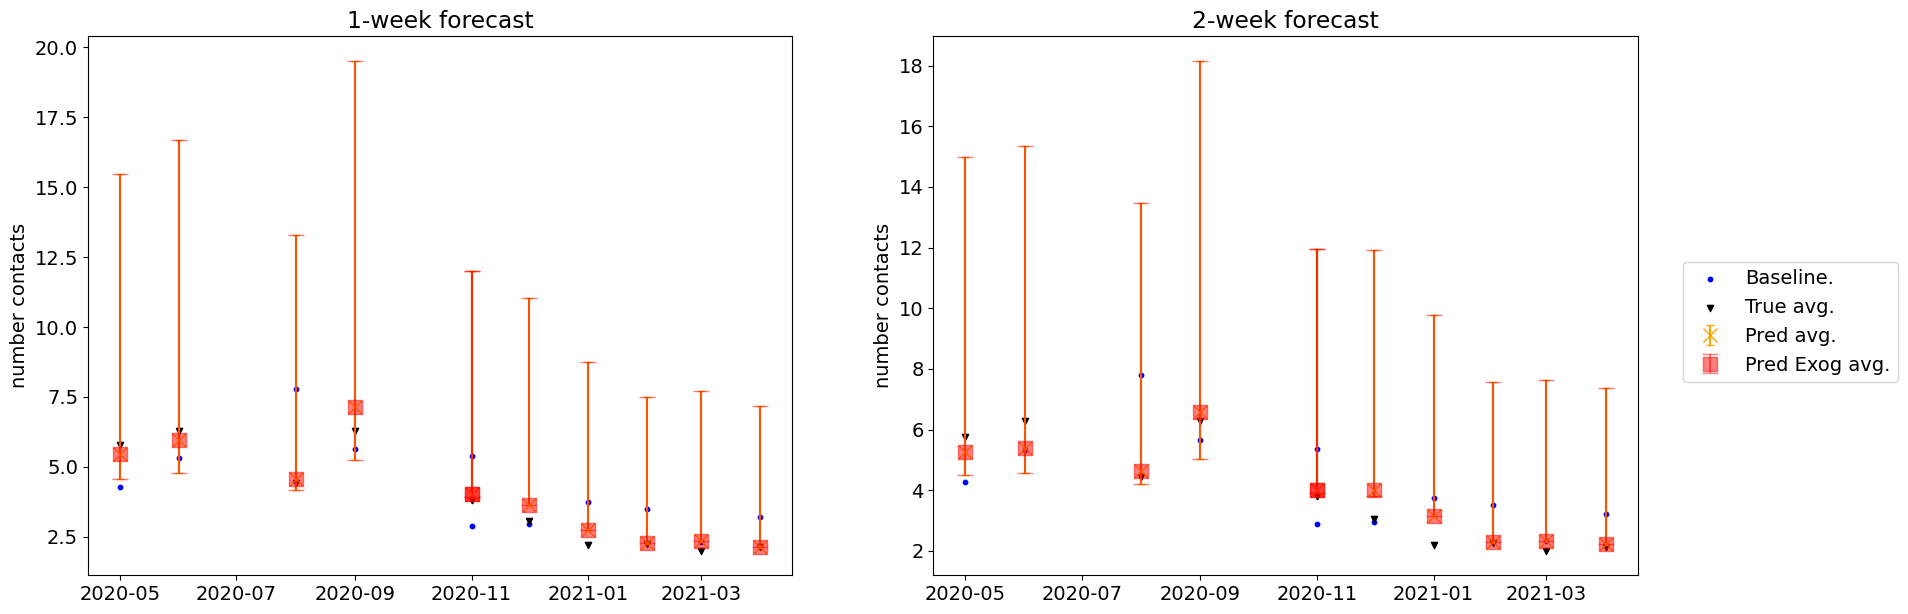

In [210]:
#save_predictions(path+exp_name+"/total_no_exog.pk", forecast_by_steps, nums= [0, 1])
save_predictions(path+exp_name+"/total_exog.pk", forecast_by_steps_exog, nums= [0, 1])
# #
fig, ax= plot_compare(df, target_col, forecast_by_steps, forecast_by_steps_exog,agg=agg)
plt.savefig(path+exp_name+"/total_comp.jpg", dpi=300, bbox_inches="tight")
#
fig, ax=plot_compare_rolling(df, target_col, forecast_by_steps, forecast_by_steps_exog,agg=agg)
plt.savefig(path+exp_name+"/total_comp_rolling.jpg", dpi=300, bbox_inches="tight")
#
fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps,agg=agg)
fig.suptitle("No Exog")
plt.savefig(path+exp_name+"/rolling_7_no_exog.jpg", dpi=300, bbox_inches="tight")
#
fig, ax=plot_with_ci_rolling(target_col, df, forecast_by_steps_exog,agg=agg)
fig.suptitle("with Exog")
plt.savefig(path+exp_name+"/rolling_7_exog.jpg", dpi=300, bbox_inches="tight")
#
metrics_df= get_metrics(df, forecast_by_steps, forecast_by_steps_exog, target_col, num_contact,agg=agg)
metrics_df.to_csv(path+exp_name+"/metrics.csv")
#
monthly_metrics_df= compare_with_monthly(df, target_col, num_contact, forecast_by_steps, forecast_by_steps_exog,agg=agg)
plt.savefig(path+exp_name+"/comp_with_monthly.jpg", dpi=300, bbox_inches="tight")

In [211]:
#plot_monthly_metrics_df(monthly_metrics_df)
#plt.savefig(path+exp_name+"/monthly_comp_mse.jpg", dpi=300, bbox_inches="tight")

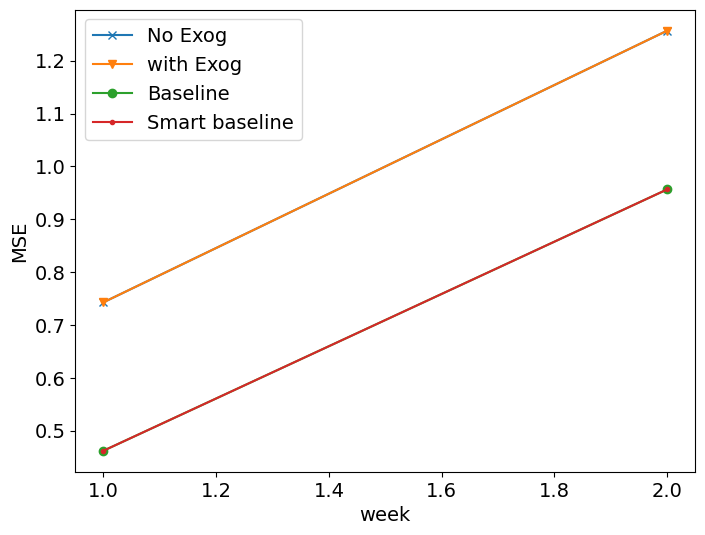

In [212]:
all_metrics= get_metrics_for_all_steps(df, forecast_by_steps, forecast_by_steps_exog, target_col,agg=agg)
plot_metrics_for_all_steps(all_metrics)
plt.savefig(path+exp_name+"/comp_mse.jpg", dpi=300, bbox_inches="tight")

In [151]:
1

1